---
title: "Multivariate GARCH with Python and Tensorflow"
author: "Sarem"
date: "2022-09-11"
categories: [Time Series, Tensorflow]
format:
  html:
    toc: true
    toc-location: left
    toc-depth: 2
    toc-title: Contents
description-meta: "One primary limitation of GARCH is the restriction to a single dimensional time-series. In reality, however, we are typically dealing with multiple time-series."
---

## Introduction

In an [earlier article](http://sarem-seitz.com/lets-make-garch-more-flexible-with-normalizing-flows/?ref=sarem-seitz.com), we discussed how to replace the conditional Gaussian assumption in a traditional GARCH model. While such gimmicks are a good start, they are far from being useful for actual applications.

One primary limitation is the obvious restriction to a single dimensional time-series. In reality, however, we are typically dealing with multiple time-series. Thus, a multivariate GARCH model would be much more appropriate.

Technically, we could fit a separate GARCH model for each series and handle interdependencies afterwards. As long as correlations between the time-series can be presumed constant, this can be a valid and straightforward solution. Once correlation becomes dynamic, however, we could lose important information that way.

As a motivating example, consider stock market returns of correlated assets. It is a commonly observed phenomenon that [asset returns' correlation tends to increase heavily during times of crisis](https://www.twosigma.com/articles/asset-class-correlations-return-to-normalcy/?ref=sarem-seitz.com). In consequence, ignoring such dynamics would be rather unreasonable given such convincing evidence.

Multivariate GARCH models, namely models for dynamic conditional correlation (DCC), are what we need in this case. The DCC model dates back to the early 2000s, starting with a seminal paper by [Robert Engle](https://www.jstor.org/stable/pdf/1392121.pdf?refreqid=excelsior%3A4cab7142cd1ac1427c35cfcfbbf8ab98&ab_segments=&origin=&acceptTC=1&ref=sarem-seitz.com). For this article, we will closely work with his notation.

## From GARCH to multivariate GARCH and DCC
Remember that, for univariate Normal GARCH, we have the following formulas:
$$
\begin{gathered}
u_{t \mid t-1} \sim \mathcal{N}\left(0 ; \sigma_{t \mid t-1}^2\right) \\
\sigma_{t \mid t-1}^2=\alpha_0+\alpha \sigma_{t-1 \mid t-2}^2+\beta u_{t-1 \mid t-2}^2 \\
\alpha_0, \alpha, \beta \geq 0 \quad \alpha+\beta<1
\end{gathered}
$$
For a deeper look at GARCH and its predecessor ARCH, I recommend reading the original papers ([ARCH](https://www.jstor.org/stable/1912773?ref=sarem-seitz.com), [GARCH](For a deeper look at GARCH and its predecessor ARCH, I recommend reading the original papers (ARCH, GARCH).)).

Over the years, numerous extensions have been proposed to address the shortcomings of this base model - for example

- [FIGARCH](http://www.stat.tugraz.at/AJS/ausg123/123Tayefi.pdf?ref=sarem-seitz.com) to model long memory of shocks in the conditional variance equation
- [EGARCH](https://vlab.stern.nyu.edu/docs/volatility/EGARCH?ref=sarem-seitz.com) for asymmetric effects of positive and negative shocks in the conditional variance
- ...and [various approaches](https://edoc.hu-berlin.de/bitstream/handle/18452/4120/20.pdf?sequence=1&ref=sarem-seitz.com) to make the conditional variance term non-linear
As we will see, all these variations of univariate GARCH can be used in a multivariate GARCH/DCC model.

## General introduction to multivariate GARCH
First, let us introduce a bi-variate random variable
$$
U_{t \mid t-1}=\left(\begin{array}{l}
u_{1, t \mid t-1} \\
u_{2, t \mid t-1}
\end{array}\right)
$$
with covariance matrix
$$
\Sigma_{t \mid t-1}=\left[\begin{array}{cc}
\sigma_{1, t \mid t-1}^2 & \sigma_{12, t \mid t-1} \\
\sigma_{12, t \mid t-1} & \sigma_{2, t \mid t-1}^2
\end{array}\right]
$$
In addition, we define
$$
\Psi_{t \mid t-1}=U_{t \mid t-1} U_{t \mid t-1}^T=\left[\begin{array}{cc}
u_{1, t \mid t-1}^2 & u_{1, t \mid t-1} u_{2, t \mid t-1} \\
u_{1, t \mid t-1} u_{2, t \mid t-1} & u_{2, t \mid t-1}^2
\end{array}\right]
$$
It can easily be seen that this matrix generalizes the squared observation term from the univariate GARCH model.

We could now generalize this to higher variate random variables and higher lag dependencies. For convenience, however, let us stick with the above.

Our goal then is to find an explicit formula to model the covariance matrix' dependency on the past. For this, we follow the tradition of GARCH models. I.e., we condition covariance linearly on past covariances **and** past realizations of the actual random variables.

Notice that the obvious linear transformation
$$
\Sigma_{t \mid t-1}=A_0+A^T \Sigma_{t-1 \mid t-2} A+B^T \Psi_{t-1 \mid t-2} B,
$$
(with $A_0, A, B \in \mathbb{R}^{2 \times 2}, A_0$ positive semi-definite) would be reasonable but highly inefficient for higher dimensions. After all, for a lag-5 model, we would already have 375 free variables. In relation to daily time-series, this is more than a year worth of data.

As a first restriction, it makes sense to avoid redundancies due to the symmetry of the covariance matrix. We introduce the following operation:
$$
\operatorname{vech}\left(\Sigma_{t \mid t-1}\right)=\left(\begin{array}{c}
\sigma_{1, t \mid t-1}^2 \\
\sigma_{1, t \mid t-1} \sigma_{2, t \mid t-1} \\
\sigma_{2, t \mid t-1}^2
\end{array}\right)
$$
Put simply, we stack all elements of the matrix into a vector while removing duplicates. This allows the following simplification to our initial multivariate GARCH model:
$$
\begin{gathered}
\operatorname{vech}\left(\Sigma_{t \mid t-1}\right)=\mathbf{a}_{\mathbf{0}}+A \operatorname{vech}\left(\Sigma_{t-1 \mid t-2}\right)+B \operatorname{vech}\left(\Psi_{t-1 \mid t-2}\right) \\
\mathbf{a}_{\mathbf{0}} \in \mathbb{R}^3 ; A, B \in \mathbb{R}^{3 \times 3}
\end{gathered}
$$
For the order 5-lag model, this specification reduces the amount of free variables to **45**. As this is still quite high, we could impose some restrictions on our model matrices, for example
$$
A=\left[\begin{array}{ccc}
a_1 & 0 & 0 \\
0 & a_2 & 0 \\
0 & 0 & a_3
\end{array}\right] \quad B=\left[\begin{array}{ccc}
b_1 & 0 & 0 \\
0 & b_2 & 0 \\
0 & 0 & b_3
\end{array}\right]
$$
i.e. the matrices a diagonal. Going back, again, to the lag-5 model, we would now be down to **15** free variables.

### Multivariate GARCH with constant and dynamic correlation
Another class of multivariate GARCH specifications has been proposed by [Bollerslev](http://public.econ.duke.edu/~boller/Published_Papers/restat_90.pdf?ref=sarem-seitz.com) and [Engle](https://www.jstor.org/stable/pdf/1392121.pdf?refreqid=excelsior%3A4cab7142cd1ac1427c35cfcfbbf8ab98&ab_segments=&origin=&acceptTC=1&ref=sarem-seitz.com). The core idea is to splitconditional covariance into conditional standard deviations and conditional correlations:
$$
\begin{aligned}
\Sigma_{t \mid t-1} & =D_{t \mid t-1} R_{t \mid t-1} D_{t \mid t-1} \\
D_{t \mid t-1} & =\left[\begin{array}{cc}
\sigma_{1, t \mid t-1} & 0 \\
0 & \sigma_{2, t \mid t-1}
\end{array}\right] \\
R_{t \mid t-1} & =\left[\begin{array}{cc}
1 & \rho_{12, t \mid t-1} \\
\rho_{12, t \mid t-1} & 1
\end{array}\right]
\end{aligned}
$$
Now, the conditional standard deviations can be modelled as the square roots of independent GARCH models. This leaves room for choosing any GARCH model that is deemed appropriate.

The correlation component can be presumed constant (= **C**onstant **c**onditional **c**orrelation, CCC) or auto-regressive (= **D**ynamic **c**onditional **c**orrelation, DCC). For the latter, we can do the following:
$$
\begin{gathered}
R_{t \mid t-1}=\left(\sqrt{\operatorname{diag}\left(Q_{t \mid t-1}\right)} \cdot I\right)^{-1} Q_{t \mid t-1}\left(\sqrt{\operatorname{diag}\left(Q_{t \mid t-1}\right)} \cdot I\right)^{-1} \\
Q_{t \mid t-1}=A_0+\left(A \circ Q_{t-1 \mid t-2}-A_0\right)+\left(B \circ \tilde{\Psi}_{t-1 \mid t-2}-A_0\right)
\end{gathered}
$$
where
$$
A_0, A, B \in \mathbb{R}^{2 \times 2}
$$
$A_0, \mathbf{1 1}^T-A-B \succcurlyeq 0$ (positive semi-definite)
and
$$
\begin{gathered}
\tilde{\Psi}_{t-1 \mid t-2}=\tilde{U}_{t-1 \mid t-2} \tilde{U}_{t-1 \mid t-2}^T \\
=\left[\begin{array}{cc}
\frac{u_{1, t-1 \mid t-2}^2}{\sigma_{1, t-1 \mid t-2}^2} & \frac{u_{1, t-1 \mid t-2}}{\sigma_{1, t-1 \mid t-2}} \frac{u_{1, t-1 \mid t-2}}{\sigma_{1, t-1 \mid t-2}} \\
\frac{u_{1, t-1 \mid t-2}}{\sigma_{1, t-1 \mid t-2}} \frac{u_{1, t-1 \mid t-2}}{\sigma_{1, t-1 \mid t-2}} & \frac{u_{2, t-1 \mid t-2}^2}{\sigma_{2, t-1 \mid t-2}^2}
\end{array}\right]
\end{gathered}
$$
As you can see, the un-normalized conditional correlation now follows an error-correction like term. Finally, to reduce the amount of free parameters, we can replace the matrices by scalars to get
$$
Q_{t \mid t-1}=A_0+\left(a \cdot Q_{t-1 \mid t-2}-A_0\right)+\left(b \cdot \tilde{\Psi}_{t-1 \mid t-2}-A_0\right)
$$
where
$$
a, b \geq 0 \quad a+b<1 .
$$
On the one hand this formulation is less expressive than before. On the other hand, ensuring stationarity is much easier from a programmatic point of view.

## Using Python and Tensorflow to implement DCC
Let us start with the full implementation and then look at the details:

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp

class MGARCH_DCC(tf.keras.Model):
    """
    Tensorflow/Keras implementation of multivariate GARCH under dynamic conditional correlation (DCC) specification.
    Further reading:
        - Engle, Robert. "Dynamic conditional correlation: A simple class of multivariate generalized autoregressive conditional heteroskedasticity models."
        - Bollerslev, Tim. "Modeling the Coherence in Short-Run Nominal Exchange Rates: A Multi-variate Generalized ARCH Model."
        - Lütkepohl, Helmut. "New introduction to multiple time series analysis."
    """
    
    def __init__(self, y):
        """
        Args:
            y: NxM numpy.array of N observations of M correlated time-series
        """
        super().__init__()
        n_dims = y.shape[1]
        self.n_dims = n_dims
        
        self.MU = tf.Variable(np.mean(y,0)) #use a mean variable
        
        self.sigma0 = tf.Variable(np.std(y,0)) #initial standard deviations at t=0
        
        #we initialize all restricted parameters to lie inside the desired range
        #by keeping the learning rate low, this should result in admissible results
        #for more complex models, this might not suffice
        self.alpha0 = tf.Variable(np.std(y,0))
        self.alpha = tf.Variable(tf.zeros(shape=(n_dims,))+0.25)
        self.beta = tf.Variable(tf.zeros(shape=(n_dims,))+0.25)
        
        self.L0 = tf.Variable(np.float32(np.linalg.cholesky(np.corrcoef(y.T)))) #decomposition of A_0
        self.A = tf.Variable(tf.zeros(shape=(1,))+0.9)
        self.B = tf.Variable(tf.zeros(shape=(1,))+0.05)
        
           
    def call(self, y):
        """
        Args:
            y: NxM numpy.array of N observations of M correlated time-series
        """
        return self.get_conditional_dists(y)
    
    
    def get_log_probs(self, y):
        """
        Calculate log probabilities for a given matrix of time-series observations
        Args:
            y: NxM numpy.array of N observations of M correlated time-series
        """
        return self.get_conditional_dists(y).log_prob(y)
    
        
    @tf.function
    def get_conditional_dists(self, y):
        """
        Calculate conditional distributions for given observations
        Args:
            y: NxM numpy.array of N observations of M correlated time-series
        """
        T = tf.shape(y)[0]
        
        #create containers for looping
        mus = tf.TensorArray(tf.float32, size = T) #observation mean container
        Sigmas = tf.TensorArray(tf.float32, size = T) #observation covariance container

        
        sigmas = tf.TensorArray(tf.float32, size = T+1)
        us = tf.TensorArray(tf.float32, size = T+1)
        Qs = tf.TensorArray(tf.float32, size = T+1)
        
        
        #initialize respective values for t=0
        sigmas = sigmas.write(0, self.sigma0)
        A0 = tf.transpose(self.L0)@self.L0
        Qs = Qs.write(0, A0) #set initial unnormalized correlation equal to mean matrix
        us = us.write(0, tf.zeros(shape=(self.n_dims,))) #initial observations equal to zero
        
        
        #convenience
        sigma0 = self.sigma0
        alpha0 = self.alpha0**2 #ensure positivity
        alpha = self.alpha
        beta = self.beta

        A = self.A
        B = self.B
        
        
        for t in tf.range(T):
            #tm1 = 't minus 1'
            #suppress conditioning on past in notation
            
            #1) calculate conditional standard deviations
            u_tm1 = us.read(t) 
            sigma_tm1 = sigmas.read(t)
            
            sigma_t = (alpha0 + alpha*sigma_tm1**2 + beta*u_tm1**2)**0.5
            
            #2) calculate conditional correlations
            u_tm1_standardized = u_tm1/sigma_tm1
                   
            Psi_tilde_tm1 = tf.reshape(u_tm1_standardized, (self.n_dims,1))@tf.reshape(u_tm1_standardized, (1,self.n_dims))

            Q_tm1 = Qs.read(t)
            Q_t = A0 + A*(Q_tm1 - A0) + B*(Psi_tilde_tm1 - A0)
            R_t = self.cov_to_corr(Q_t)
            
            #3) calculate conditional covariance
            D_t = tf.linalg.LinearOperatorDiag(sigma_t)
            Sigma_t = D_t@R_t@D_t
              
            
            #4) store values for next iteration
            sigmas = sigmas.write(t+1, sigma_t)
            us = us.write(t+1, y[t,:]-self.MU) #we want to model the zero-mean disturbances
            Qs = Qs.write(t+1, Q_t)
            
            mus = mus.write(t, self.MU)
            Sigmas = Sigmas.write(t, Sigma_t)
            
        return tfp.distributions.MultivariateNormalFullCovariance(mus.stack(), Sigmas.stack())
    
    
    def cov_to_corr(self, S):
        """
        Transforms covariance matrix to a correlation matrix via matrix operations
        Args:
            S: Symmetric, positive semidefinite covariance matrix (tf.Tensor)
        """
        D = tf.linalg.LinearOperatorDiag(1/(tf.linalg.diag_part(S)**0.5))
        return D@S@D
        
    

    def train_step(self, data):
        """
        Custom training step to handle keras model.fit given that there is no input-output structure in our model
        Args:
            S: Symmetric, positive semidefinite covariance matrix (tf.Tensor)
        """
        x,y = data
        with tf.GradientTape() as tape:
            loss = -tf.math.reduce_mean(self.get_log_probs(y))
            
        trainable_vars = self.trainable_weights
        gradients = tape.gradient(loss, trainable_vars)
        
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        
        return {"Current loss": loss}
    
    
    
    def sample_forecast(self, y, T_forecast = 30, n_samples=500):
        """
        Create forecast samples to use for monte-carlo simulation of quantities of interest about the forecast (e.g. mean, var, corr, etc.)
        WARNING: This is not optimized very much and can take some time to run, probably due to Python's slow loops - can likely be improved
        Args:
            y: numpy.array of training data, used to initialize the forecast values
            T_forecast: number of periods to predict (integer)
            n_samples: Number of samples to draw (integer)
        """
        T = tf.shape(y)[0]
        
        #create lists for looping; no gradients, thus no tf.TensorArrays needed
        #can initialize directly
        mus = []
        Sigmas = []

        us = [tf.zeros(shape=(self.n_dims,))]
        sigmas = [self.sigma0]        
        Qs = []
        
        #initialize remaining values for t=0
        A0 = tf.transpose(self.L0)@self.L0
        Qs.append(A0)
        
        
        #convenience
        sigma0 = self.sigma0 
        alpha0 = self.alpha0**2 #ensure positivity
        alpha = self.alpha
        beta = self.beta

        A = self.A
        B = self.B
        
        #'warmup' to initialize latest lagged features
        for t in range(T):
            #tm1 = 't minus 1'
            #suppress conditioning on past in notation
            u_tm1 = us[-1]
            sigma_tm1 = sigmas[-1]
            
            sigma_t = (alpha0 + alpha*sigma_tm1**2 + beta*u_tm1**2)**0.5
            
            u_tm1_standardized = u_tm1/sigma_tm1
            
            Psi_tilde_tm1 = tf.reshape(u_tm1_standardized, (self.n_dims,1))@tf.reshape(u_tm1_standardized, (1,self.n_dims))

            Q_tm1 = Qs[-1]
            Q_t = A0 + A*(Q_tm1 - A0) + B*(Psi_tilde_tm1 - A0)
            R_t = self.cov_to_corr(Q_t)
            
            D_t = tf.linalg.LinearOperatorDiag(sigma_t)
            Sigma_t = D_t@R_t@D_t
              
            
            sigmas.append(sigma_t)
            us.append(y[t,:]-self.MU) #we want to model the zero-mean disturbances
            Qs.append(Q_t)
            
            mus.append(self.MU)
            Sigmas.append(Sigma_t)
  
            
        #sample containers
        y_samples = []
        R_samples = []
        sigma_samples = []
        
        
        for n in range(n_samples):
            
            mus_samp = []
            Sigmas_samp = []

            sigmas_samp = [sigmas[-1]]
            us_samp = [us[-1]]
            Qs_samp = [Qs[-1]]
            
            #forecast containers
            ys_samp = []
            sig_samp = []
            R_samp = [] 
            
            
            for t in range(T_forecast):
                u_tm1 = us_samp[-1]
                sigma_tm1 = sigmas_samp[-1]

                sigma_t = (alpha0 + alpha**2 + beta*u_tm1**2)**0.5

                u_tm1_standardized = u_tm1/sigma_tm1
                
                Psi_tilde_tm1 = tf.reshape(u_tm1_standardized, (self.n_dims,1))@tf.reshape(u_tm1_standardized, (1,self.n_dims))

                Q_tm1 = Qs_samp[-1]
                Q_t = A0 + A*(Q_tm1 - A0) + B*(Psi_tilde_tm1 - A0)
                R_t = self.cov_to_corr(Q_t)

                D_t = tf.linalg.LinearOperatorDiag(sigma_t)
                Sigma_t = D_t@R_t@D_t


                sigmas_samp.append(sigma_t)
                Qs_samp.append(Q_t)
                
                ynext = tfp.distributions.MultivariateNormalFullCovariance(self.MU, Sigma_t).sample()
                ys_samp.append(tf.reshape(ynext,(1,1,-1)))
                sig_samp.append(tf.reshape(sigma_t,(1,1,-1)))
                R_samp.append(tf.reshape(R_t,(1,1,self.n_dims,self.n_dims)))
                
                us_samp.append(ynext-self.MU)
                
            y_samples.append(tf.concat(ys_samp,1))
            R_samples.append(tf.concat(R_samp,1))
            sigma_samples.append(tf.concat(sig_samp,1))
        
        return tf.concat(y_samples,0).numpy(), tf.concat(R_samples,0).numpy(), tf.concat(sigma_samples,0).numpy()

While the code is quite lengthy, its primary purpose is only twofold:

1. **Calculate the in-sample distribution** (get_conditional_dists(...)) - is needed for optimization via [maximum likelihood](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation?ref=sarem-seitz.com). This function calculates the likelihood values of each observation given the MGARCH model.
2. **Forecast the out-of sample distribution** (sample_forecast(...)) - as the formulas for the model as a whole are quite complex, it's difficult to calculate the forecast distributions in closed form. However, we can, more or less, easily sample from the target distribution. With a sufficiently large sample, we can estimate all relevant quantities of interest (e.g. forecast mean and quantiles).

Notice that here, we have specified the conditional distribution as a multivariate Gaussian. Given the theory from above, this is nevertheless not a necessity. A multivariate T-distribution, for example, could work equally well or even better. Obviously, though, a Gaussian is always nice to work with.

Now, the remaining functions are basically just helpers to maintain some structure. I decided to not break down the key functions down further in order to keep the calculations in one place. If we were unit testing our model, it would actually be sensible to split things up into better testable units.

As we want to use the Keras API for training, we need to customize the training procedure (train_step(...)). Contrary to typical Keras use-cases, our training data is not split between input and output data. Rather, we only have one set of data, namely the time-series observations.

Finally, each training step needs to process all training observations at once. (**no mini-batching**). Also the observations must always remain in order (**no shuffling**).

This yields the following generic training loop:

`model.fit(ts_data, ts_data, batch_size=len(ts_data), shuffle=False, epochs = 300, verbose=False)
`

## Multivariate GARCH in Python - an example
We can now test our model on a simple example and see what happens. Given Python's seamless interaction with [Yahoo Finance](https://finance.yahoo.com/?ref=sarem-seitz.com), we can pull some data for **DAX** and **S&P 500**:

[*********************100%***********************]  2 of 2 completed


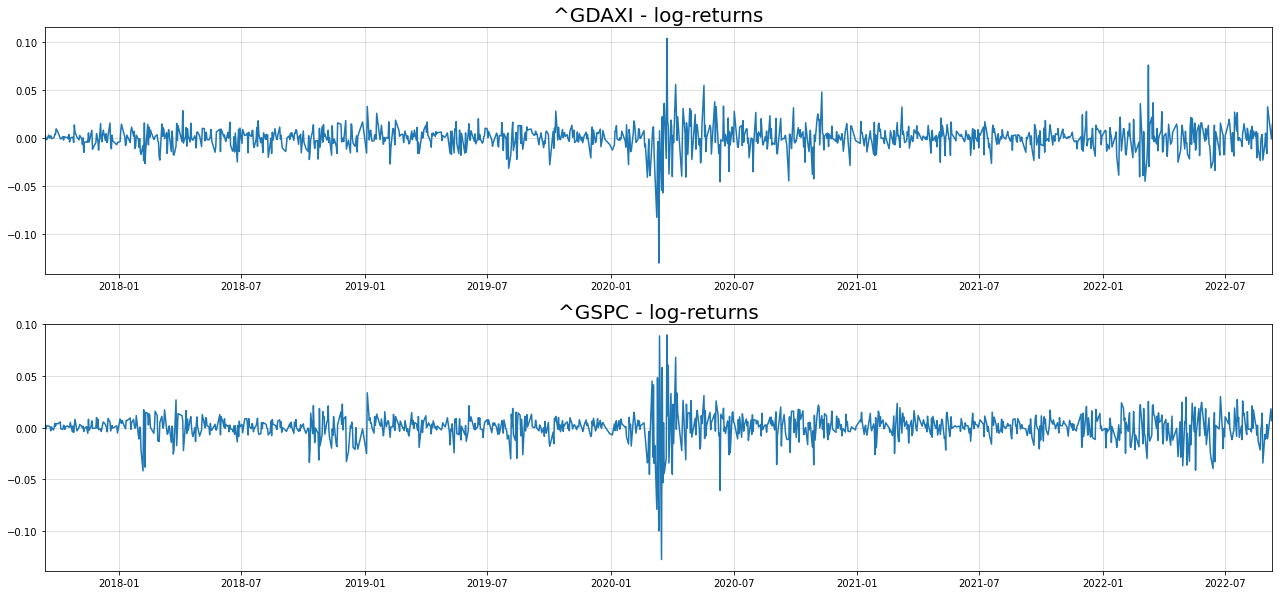

In [9]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

data = yf.download("^GDAXI ^GSPC", start="2017-09-10", end="2022-09-10", interval="1d")

close = data["Close"]
returns = np.log(close).diff().dropna()

fig, axs = plt.subplots(2,1, figsize = (22,5*2))

for i in range(2):
    axs[i].plot(returns.iloc[:,i])
    axs[i].grid(alpha=0.5)
    axs[i].margins(x=0)
    axs[i].set_title("{} - log-returns".format(returns.columns[i]),size=20)

The typical volatility clusters are visible for both time-series. To see what happens with correlation between both stocks over time, we can plot the 60-day rolling correlation:

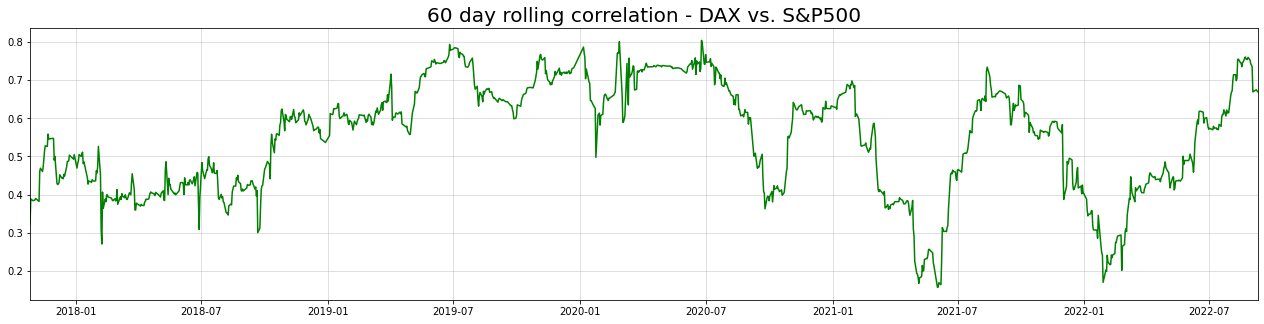

In [3]:
import pandas as pd

rolling_corrs = returns.rolling(60,min_periods=0).corr()
gdaxi_sp500_rollcorr = rolling_corrs["^GDAXI"][rolling_corrs.index.get_level_values(1)=="^GSPC"]

plt.figure(figsize = (22,5))

plt.title("60 day rolling correlation - DAX vs. S&P500",size=20)
plt.plot(returns.index[30:],gdaxi_sp500_rollcorr.values[30:],c="green", label="60 day rolling correlation")
plt.grid(alpha=0.5)
plt.margins(x=0)

It appears as if correlation between both indices has dropped since the beginning of the pandemic. Afterwards, correlation seems to fluctuate in cycles.

All in all, the pattern looks like a discretized version of an [Ornstein-Uhlenbeck process](https://towardsdatascience.com/stochastic-processes-simulation-the-ornstein-uhlenbeck-process-e8bff820f3?ref=sarem-seitz.com). The error correction formulation in our model should be able to capture this behaviour accordingly.

After splitting the data into train and test set (**last 90 observations**), we can fit the model. Then we take samples from the (**90 days ahead**) forecast distribution as follows (this takes some time):

In [7]:
np.random.seed(123)
tf.random.set_seed(123)


train = np.float32(returns)[:-90,:]
test = np.float32(returns)[-90:,:]

model = MGARCH_DCC(train)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2))
model.fit(train, train, batch_size=len(train), shuffle=False, epochs = 300, verbose=False)

fcast = model.sample_forecast(train,90,1000)

Now, we are particularly interested in the conditional correlation fit and forecasts:

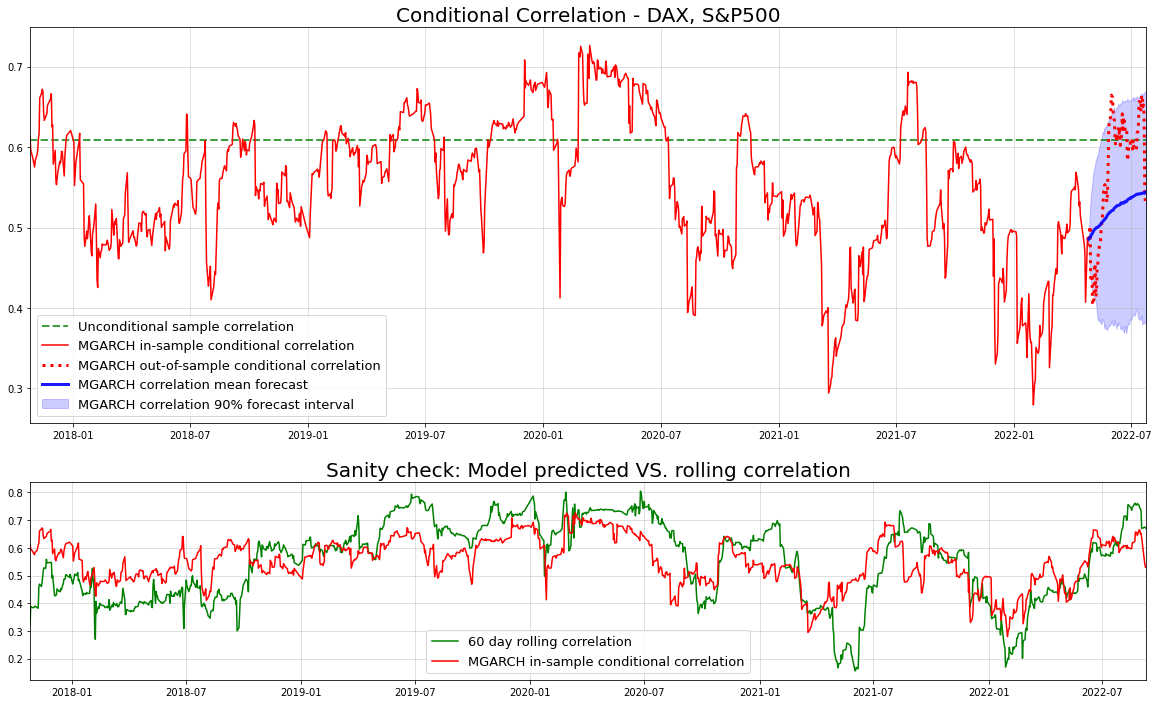

In [8]:
from datetime import timedelta

corrs = fcast[1][:,:,0,1]
corr_means = np.mean(corrs,0)
corr_lowers = np.quantile(corrs,0.05,0)
corr_uppers = np.quantile(corrs,0.95,0)


conditional_dists = model(np.float32(returns.values))

conditional_correlations = [model.cov_to_corr(conditional_dists.covariance()[i,:,:])[0,1].numpy() for i in range(len(returns))]

idx_train = returns[:-90].index
idx_test = pd.date_range(returns[:-90].index[-1] + timedelta(days=1), returns[:-90].index[-1] + timedelta(days=90))

fig, axs = plt.subplots(2,1,figsize=(20,12), gridspec_kw={'height_ratios': [2, 1]})

axs[0].set_title("Conditional Correlation - DAX, S&P500", size=20)

axs[0].axhline(np.corrcoef(returns.T)[0,1], c="green",alpha=0.75,ls="dashed",lw=2, label="Unconditional sample correlation")

axs[0].plot(idx_train[30:],conditional_correlations[30:-90],c="red", label="MGARCH in-sample conditional correlation")
axs[0].plot(idx_test,conditional_correlations[-90:],c="red",ls="dotted",lw=3, label="MGARCH out-of-sample conditional correlation")

axs[0].plot(idx_test, corr_means,color="blue",lw=3, alpha=0.9, label="MGARCH correlation mean forecast")
axs[0].fill_between(idx_test, corr_lowers, corr_uppers, color="blue", alpha=0.2, label="MGARCH correlation 90% forecast interval")

axs[0].grid(alpha=0.5)
axs[0].legend(prop = {"size":13})
axs[0].margins(x=0)


axs[1].set_title("Sanity check: Model predicted VS. rolling correlation",size=20)
axs[1].plot(returns.index[30:],gdaxi_sp500_rollcorr.values[30:],c="green", label="60 day rolling correlation")
axs[1].plot(returns.index[30:],conditional_correlations[30:],c="red", label="MGARCH in-sample conditional correlation")
axs[1].grid(alpha=0.5)
axs[1].legend(prop = {"size":13})
axs[1].margins(x=0)

The forecasted correlation (blue) captures the actual correlation (red) under our model quite well. Obviously though, the true correlation is unknown. Nevertheless, our model matches the rolling correlation quite well, even out-of sample. This implies that our approach is - at least - not completely off.

Being able to reliably forecast correlations might be interesting for [statistical arbitrage](https://www.investopedia.com/terms/s/statisticalarbitrage.asp?ref=sarem-seitz.com) strategies. While those strategies typically use price movements, correlations could be an interesting alternative.

From here, we could also look at price and volatility forecasts as well. To keep this article from becoming bloated, I'll leave it to the interested reader to do this. You can find the relevant notebook [here](https://github.com/SaremS/sample_notebooks/blob/master/Multivariate%20GARCH.ipynb?ref=sarem-seitz.com) - feel free to extend with your own experiments.

## Conclusion
Today, we took a look at multivariate extensions to GARCH-type models. While a 'naive' extension is quite straightforward, we need to be careful not to overparameterize our model. Luckily, there already exists research on useful specifications that mostly avoid this issue.

For deeper insights, it is likely interesting to consider non-linear extensions to this approach. The trade-off between overfitting and flexibility will possible be even more relevant here. If you want to head into that direction, you might want to have a look at [some results from Google Scholar](https://scholar.google.com/scholar?hl=de&as_sdt=0%2C5&q=multivariate+garch+nonlinear&btnG=&ref=sarem-seitz.com).

## References
**[1]** Bollerslev, Tim. Modelling the coherence in short-run nominal exchange rates: a multivariate generalized ARCH model. The review of economics and statistics, 1990, p. 498-505.

**[2]** Engle, Robert. Dynamic conditional correlation: A simple class of multivariate generalized autoregressive conditional heteroskedasticity models. Journal of Business & Economic Statistics 20.3, 2002, p. 339-350.

**[3]** Lütkepohl, Helmut. New introduction to multiple time series analysis. Springer Science & Business Media, 2005.